In [313]:
import numpy as np
from numpy import genfromtxt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

### Questions

#### Question 1

Knowing the goal of the our technology, define a metric to measure our performance. Calculate that performance score for each of the companies in the dataset.

#### Question 2

##### 2.1
How can we know whether a payload is the first payload of a viewer's session?

##### 2.2
Add a column `isFirstPayload` to the dataset, that must be `True` if the row represents a payload that was **the first payload** sent by a viewer, and `False` otherwise.

##### 2.3
Use that column to calculate the **number of distinct viewers** that sent payloads for each company.

#### Question 3

##### 3.1
Let's consider a viewer A who starts a video at T=0, then has a playback error at **T = 2 minutes 30 seconds**, and then another one at **T=6 minutes 20 seconds**. What will be the values of the fields `playbackErrorCount` and `totalPlaybackErrorCount` in the first 5 payloads sent by viewer A?

##### 3.2
Calculate the **number of distinct viewers** that had **at least 1** playback error during their session.

#### Question 4

In this question, we only focus on customer **Streamr\*\*\*\* TV**.

We define the _concurrency_ as the number of viewers connected simustaneously on the **same content**, i.e the number of payloads we received during a given 2 minutes window on a given content.

##### 4.1
Add a column "readableDate" to the dataset that will be the beginning of the 2 minutes window during which the payload was sent. For example, if a payload was sent at 11:35, the column "readableDate" should be 11:34, if a payload was sent at 10:03, the "readableDate" should be 10:02.

##### 4.2
Plot the concurrency time series for the content `content-05335`.

##### 4.3
What is the average performance measured when the concurrency is lower than 10?

##### 4.4
Starting from which concurrency can we say there is a 75% chance that the performance on a content is higher than 80%?



We develop a technology that allows a viewer watching a video online to download the video data either from the broadcaster's Content Delivery Network ('CDN') or from a Peer to Peer Network, using other viewers on the same stream as sources.

During their session, each viewer sends payloads **every two minutes**, containing some metrics collected by our P2P client. The dataset attached to this file (**dstest.zip**) is a sample of those payloads. Each row is a payload sent by a viewer, and has the following columns:

* **company** : The name of the company providing the stream being watched by the user that sent the payload
* **live** : A string indicating if the video being watched is a live stream or a VOD stream
* **content** : The name of the content being watched by the viewer sending the payload
* **p2p** : The volume of data (in bytes) **downloaded through the P2P network** from other viewers during the payload timespan (2 minutes)
* **cdn** : The volume of data (in bytes) **downloaded the CDN** during the payload timespan (2 minutes)
* **upload** : The volume of data (in bytes) **uploaded to other viewers** on the P2P network during the payload timespan (2 minutes)
* **peers_count** : Average number of peers connected to the users during the payload timespan
* **timestamp** : Unix timestamp (UTC) of the moment the payload was sent
* **sessionDuration** : **Total time** elapsed since the beginning of the video session (in milliseconds)
* **playbackErrorCount** : Number of playback errors that occurred during the payload timespan
* **totalPlaybackErrorCount** : Number of playback errors that have occurred since the beginning of the viewer's session



### Importing the data to the notebook

In [244]:
col_names = pd.read_csv('dstest.csv', nrows=0).columns
types_dict = {'p2p': int, 'cdn': int, 'upload':int, 'peers_count':float, 'sessionDuration':int, 'playbackErrorCount': int, 'totalPlaybackErrorCount':int, 'timestamp':int}
types_dict.update({col: str for col in col_names if col not in types_dict})


In [245]:
df=pd.read_csv('dstest.csv', dtype=types_dict)

In [246]:
df.dtypes

company                     object
live                        object
mediaEngine                 object
p2p                          int64
cdn                          int64
upload                       int64
peers_count                float64
peers_match                 object
timestamp                    int64
sessionDuration              int64
playbackErrorCount           int64
totalPlaybackErrorCount      int64
content                     object
dtype: object

In [247]:
df['timestamp']=pd.to_datetime(df['timestamp'],unit='ms')

In [248]:
df

,company,live,mediaEngine,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount,content
0,Streamroot TV,VOD,ME1,0,8507376,0,0.00,1,2019-07-07 03:23:27.407,120000,0,0,content-09235
1,Streamroot TV,VOD,ME1,0,5778744,0,0.00,0,2019-07-07 03:25:27.310,240000,0,0,content-09235
2,Streamroot TV,VOD,ME1,0,7692960,0,0.00,0,2019-07-07 03:27:27.330,360000,0,0,content-09235
3,Streamroot TV,VOD,ME1,0,8229888,0,0.00,0,2019-07-07 03:29:27.720,480000,0,0,content-09235
4,Streamroot TV,VOD,ME1,0,10387000,0,0.00,0,2019-07-07 03:31:27.353,600000,0,0,content-09235
...,...,...,...,...,...,...,...,...,...,...,...,...,...
385160,Streamroot TV,VOD,ME1,14849556,0,76800,19.98,40,2019-07-07 05:50:31.672,1800000,0,0,content-05335
385161,Streamroot TV,VOD,ME1,12287680,0,417400,19.77,40,2019-07-07 05:52:29.635,1920000,0,0,content-05335
385162,Streamroot TV,VOD,ME1,13229184,0,6588,19.70,40,2019-07-07 05:54:29.650,2040000,0,0,content-05335
385163,Streamroot TV,VOD,ME1,3515600,0,2000896,19.23,40,2019-07-07 05:56:29.910,2160000,0,0,content-05335


#### Question 1

Knowing the goal of the our technology, define a metric to measure our performance. Calculate that performance score for each of the companies in the dataset.

#### Answer
One of the metric to measure performance can be bit load which is measured in Mbps. 
##### Formula for calcultation 
##### (p2p + cdn)*coef/payload_timespan
##### p2p - the volume of data (in bytes) downloaded through the P2P network 
##### cdn - the volume of data (in bytes) downloaded the CDN
##### payload_timespan - 120 sec
##### coef - coefficient to convert bytes in Mb, equal 0.0000076294

In [249]:
df['bitLoad'] = (df['p2p'] + df['cdn'])*0.0000076294*0.0083333

In [250]:
df

,company,live,mediaEngine,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount,content,bitLoad
0,Streamroot TV,VOD,ME1,0,8507376,0,0.00,1,2019-07-07 03:23:27.407,120000,0,0,content-09235,0.540883
1,Streamroot TV,VOD,ME1,0,5778744,0,0.00,0,2019-07-07 03:25:27.310,240000,0,0,content-09235,0.367401
2,Streamroot TV,VOD,ME1,0,7692960,0,0.00,0,2019-07-07 03:27:27.330,360000,0,0,content-09235,0.489104
3,Streamroot TV,VOD,ME1,0,8229888,0,0.00,0,2019-07-07 03:29:27.720,480000,0,0,content-09235,0.523240
4,Streamroot TV,VOD,ME1,0,10387000,0,0.00,0,2019-07-07 03:31:27.353,600000,0,0,content-09235,0.660386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385160,Streamroot TV,VOD,ME1,14849556,0,76800,19.98,40,2019-07-07 05:50:31.672,1800000,0,0,content-05335,0.944106
385161,Streamroot TV,VOD,ME1,12287680,0,417400,19.77,40,2019-07-07 05:52:29.635,1920000,0,0,content-05335,0.781227
385162,Streamroot TV,VOD,ME1,13229184,0,6588,19.70,40,2019-07-07 05:54:29.650,2040000,0,0,content-05335,0.841086
385163,Streamroot TV,VOD,ME1,3515600,0,2000896,19.23,40,2019-07-07 05:56:29.910,2160000,0,0,content-05335,0.223515


In [251]:
df.groupby('company')['bitLoad'].mean()

company
Flash Infos      1.501367
Sports News      2.859227
Streamroot TV    0.995479
Name: bitLoad, dtype: float64

### Question 2

### 2.1
How can we know whether a payload is the first payload of a viewer's session?

### Answer
The first payload is a paylod with a sessionDuration (total time elapsed since the beginning of the video session (in milliseconds)) equal to 2 minutes or 120000 ms



### 2.2
Add a column `isFirstPayload` to the dataset, that must be `True` if the row represents a payload that was **the first payload** sent by a viewer, and `False` otherwise.



In [252]:
df['isFirstPayload'] = np.where(df['sessionDuration'] == 120000, True, False)

In [253]:
df

,company,live,mediaEngine,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount,content,bitLoad,isFirstPayload
0,Streamroot TV,VOD,ME1,0,8507376,0,0.00,1,2019-07-07 03:23:27.407,120000,0,0,content-09235,0.540883,True
1,Streamroot TV,VOD,ME1,0,5778744,0,0.00,0,2019-07-07 03:25:27.310,240000,0,0,content-09235,0.367401,False
2,Streamroot TV,VOD,ME1,0,7692960,0,0.00,0,2019-07-07 03:27:27.330,360000,0,0,content-09235,0.489104,False
3,Streamroot TV,VOD,ME1,0,8229888,0,0.00,0,2019-07-07 03:29:27.720,480000,0,0,content-09235,0.523240,False
4,Streamroot TV,VOD,ME1,0,10387000,0,0.00,0,2019-07-07 03:31:27.353,600000,0,0,content-09235,0.660386,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385160,Streamroot TV,VOD,ME1,14849556,0,76800,19.98,40,2019-07-07 05:50:31.672,1800000,0,0,content-05335,0.944106,False
385161,Streamroot TV,VOD,ME1,12287680,0,417400,19.77,40,2019-07-07 05:52:29.635,1920000,0,0,content-05335,0.781227,False
385162,Streamroot TV,VOD,ME1,13229184,0,6588,19.70,40,2019-07-07 05:54:29.650,2040000,0,0,content-05335,0.841086,False
385163,Streamroot TV,VOD,ME1,3515600,0,2000896,19.23,40,2019-07-07 05:56:29.910,2160000,0,0,content-05335,0.223515,False



### 2.3
Use that column to calculate the **number of distinct viewers** that sent payloads for each company.

In [254]:
df.groupby('company')['isFirstPayload'].sum()

company
Flash Infos        805.0
Sports News        115.0
Streamroot TV    19914.0
Name: isFirstPayload, dtype: float64

### Question 3
### 3.1
Let's consider a viewer A who starts a video at T=0, then has a playback error at T = 2 minutes 30 seconds, and then another one at T=6 minutes 20 seconds. What will be the values of the fields playbackErrorCount and totalPlaybackErrorCount in the first 5 payloads sent by viewer A?


In [255]:
data = {'timestamp': ['02:00', '04:00', '06:00', '08:00', '10:00'], 'playbackErrorCount': [0, 1, 0, 1,0], 'totalPlaybackErrorCoun': [0, 1, 1, 2, 2]}  
firstPayloads = pd.DataFrame(data) 
firstPayloads

,timestamp,playbackErrorCount,totalPlaybackErrorCoun
0,02:00,0,0
1,04:00,1,1
2,06:00,0,1
3,08:00,1,2
4,10:00,0,2


### 3.2
Calculate the **number of distinct viewers** that had **at least 1** playback error during their session.

### Answer 
the **number of distinct viewers**  is equal to 11

In [256]:
len(df.loc[(df['playbackErrorCount'] > 0) & (df['playbackErrorCount'] == df['totalPlaybackErrorCount']),:].index)

11

#### Question 4

In this question, we only focus on customer **Streamr\*\*\*\* TV**.

We define the _concurrency_ as the number of viewers connected simustaneously on the **same content**, i.e the number of payloads we received during a given 2 minutes window on a given content.

##### 4.1
Add a column "readableDate" to the dataset that will be the beginning of the 2 minutes window during which the payload was sent. For example, if a payload was sent at 11:35, the column "readableDate" should be 11:34, if a payload was sent at 10:03, the "readableDate" should be 10:02.

##### 4.2
Plot the concurrency time series for the content `content-05335`.

##### 4.3
What is the average performance measured when the concurrency is lower than 10?

##### 4.4
Starting from which concurrency can we say there is a 75% chance that the performance on a content is higher than 80%?

In [257]:
streamroot=df.loc[lambda df1: df1['company'] == 'Streamroot TV',:]

### 4.1
Add a column "readableDate" to the dataset that will be the beginning of the 2 minutes window during which the payload was sent. For example, if a payload was sent at 11:35, the column "readableDate" should be 11:34, if a payload was sent at 10:03, the "readableDate" should be 10:02.


In [314]:
streamroot['readableDate'] = streamroot['timestamp'] - timedelta(minutes=1)

In [259]:
streamroot

,company,live,mediaEngine,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount,content,bitLoad,isFirstPayload,readableDate
0,Streamroot TV,VOD,ME1,0,8507376,0,0.00,1,2019-07-07 03:23:27.407,120000,0,0,content-09235,0.540883,True,2019-07-07 03:22:27.407
1,Streamroot TV,VOD,ME1,0,5778744,0,0.00,0,2019-07-07 03:25:27.310,240000,0,0,content-09235,0.367401,False,2019-07-07 03:24:27.310
2,Streamroot TV,VOD,ME1,0,7692960,0,0.00,0,2019-07-07 03:27:27.330,360000,0,0,content-09235,0.489104,False,2019-07-07 03:26:27.330
3,Streamroot TV,VOD,ME1,0,8229888,0,0.00,0,2019-07-07 03:29:27.720,480000,0,0,content-09235,0.523240,False,2019-07-07 03:28:27.720
4,Streamroot TV,VOD,ME1,0,10387000,0,0.00,0,2019-07-07 03:31:27.353,600000,0,0,content-09235,0.660386,False,2019-07-07 03:30:27.353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385160,Streamroot TV,VOD,ME1,14849556,0,76800,19.98,40,2019-07-07 05:50:31.672,1800000,0,0,content-05335,0.944106,False,2019-07-07 05:49:31.672
385161,Streamroot TV,VOD,ME1,12287680,0,417400,19.77,40,2019-07-07 05:52:29.635,1920000,0,0,content-05335,0.781227,False,2019-07-07 05:51:29.635
385162,Streamroot TV,VOD,ME1,13229184,0,6588,19.70,40,2019-07-07 05:54:29.650,2040000,0,0,content-05335,0.841086,False,2019-07-07 05:53:29.650
385163,Streamroot TV,VOD,ME1,3515600,0,2000896,19.23,40,2019-07-07 05:56:29.910,2160000,0,0,content-05335,0.223515,False,2019-07-07 05:55:29.910


### 4.2
Plot the concurrency time series for the content content-05335.

In [304]:
concurrency=streamroot.loc[lambda df1: df1['content'] == 'content-05335',:]

In [305]:
concurrency

,company,live,mediaEngine,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount,content,bitLoad,isFirstPayload,readableDate
2003,Streamroot TV,VOD,ME1,30264864,1469724,2657888,17.71,47,2019-07-07 05:40:05.292,120000,0,0,content-05335,2.017624,True,2019-07-07 05:39:05.292
2004,Streamroot TV,VOD,ME1,58944768,0,1306652,19.63,40,2019-07-07 05:42:05.208,240000,0,0,content-05335,3.747595,False,2019-07-07 05:41:05.208
2005,Streamroot TV,VOD,ME1,82727332,0,168960,19.78,40,2019-07-07 05:44:05.079,360000,0,0,content-05335,5.259645,False,2019-07-07 05:43:05.079
2006,Streamroot TV,VOD,ME1,30520672,0,1455280,19.88,40,2019-07-07 05:46:05.070,480000,0,0,content-05335,1.940446,False,2019-07-07 05:45:05.070
2007,Streamroot TV,VOD,ME1,4555240,0,3689216,19.23,40,2019-07-07 05:48:05.092,600000,0,0,content-05335,0.289613,False,2019-07-07 05:47:05.092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385160,Streamroot TV,VOD,ME1,14849556,0,76800,19.98,40,2019-07-07 05:50:31.672,1800000,0,0,content-05335,0.944106,False,2019-07-07 05:49:31.672
385161,Streamroot TV,VOD,ME1,12287680,0,417400,19.77,40,2019-07-07 05:52:29.635,1920000,0,0,content-05335,0.781227,False,2019-07-07 05:51:29.635
385162,Streamroot TV,VOD,ME1,13229184,0,6588,19.70,40,2019-07-07 05:54:29.650,2040000,0,0,content-05335,0.841086,False,2019-07-07 05:53:29.650
385163,Streamroot TV,VOD,ME1,3515600,0,2000896,19.23,40,2019-07-07 05:56:29.910,2160000,0,0,content-05335,0.223515,False,2019-07-07 05:55:29.910


In [306]:
result = concurrency.groupby(pd.Grouper(key="timestamp", freq="2min")).count()
result = result['company']
result

timestamp
2019-07-07 00:02:00     1
2019-07-07 00:04:00     1
2019-07-07 00:06:00     2
2019-07-07 00:08:00     2
2019-07-07 00:10:00     2
                       ..
2019-07-07 05:50:00    25
2019-07-07 05:52:00    25
2019-07-07 05:54:00    23
2019-07-07 05:56:00    26
2019-07-07 05:58:00    26
Freq: 2T, Name: company, Length: 179, dtype: int64

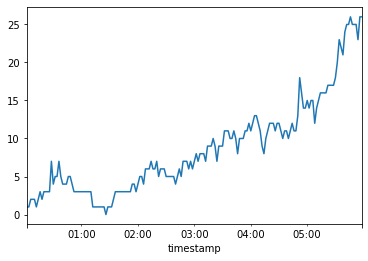

In [307]:
result.plot()

### 4.3
What is the average performance measured when the concurrency is lower than 10?
### Answer 
Average performance measured when the concurrency is lower than 10: 0.85673563480514

In [308]:
bitload = concurrency.groupby(pd.Grouper(key="timestamp", freq="2min")).mean()
bitload = bitload['bitLoad']
bitload

timestamp
2019-07-07 00:02:00    2.845514
2019-07-07 00:04:00    2.998580
2019-07-07 00:06:00    3.494151
2019-07-07 00:08:00    3.523112
2019-07-07 00:10:00    1.786202
                         ...   
2019-07-07 05:50:00    0.469322
2019-07-07 05:52:00    0.817159
2019-07-07 05:54:00    0.389277
2019-07-07 05:56:00    0.274026
2019-07-07 05:58:00    0.291411
Freq: 2T, Name: bitLoad, Length: 179, dtype: float64

In [310]:
result = result.to_frame().merge(bitload, on = 'timestamp')

In [311]:
result.columns = ['concurrency', 'bitLoad']

In [312]:
result.loc[lambda df1: df1['concurrency'] < 10,:].mean()[1]

0.85673563480514